<a href="https://colab.research.google.com/github/murtazahussainii/ToDo/blob/main/Another_copy_of_Lab6_Brats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BRATS Dataset Processing: Acquisition, Preprocessing, and Segmentation

In this notebook, we:

1. **Acquire** a 3D medical image from the BRATS dataset.
2. **Preprocess** the image by:
    - Reducing noise with a Gaussian filter.
    - Normalizing the intensities.
    - Enhancing contrast using histogram equalization.
3. **Segment** the image using to extract regions of interest.

 This pipeline is a simple starting point. More advanced segmentation may involve deep learning models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1: Image Acquisition

 We load the BRATS image (assumed to be in NIfTI format) using `nibabel`.

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Path to the BRATS sample image
brats_file = '/content/drive/MyDrive/files/BraTS20_Training_001_flair.nii'

# Load the NIfTI image
img_nifti = nib.load(brats_file)
img_data = img_nifti.get_fdata()  # This gives a 3D numpy array

print("Image shape:", img_data.shape)


# Select the middle slice along the z-axis for visualization
slice_index = img_data.shape[2] // 2
slice_img = img_data[:, :, slice_index]


print("Slice shape:", slice_img.shape)

Image shape: (240, 240, 155)
Slice shape: (240, 240)


In [ ]:
import ipywidgets as widgets
from IPython.display import display

def view_slice(axis, index):
    """
    Display a 2D slice from the 3D volume along the specified axis.

    Parameters:
        axis (str): 'x', 'y', or 'z'
        index (int): slice index along the selected axis
    """
    if axis == 'x':
        slice_img = img_data[index, :, :]
    elif axis == 'y':
        slice_img = img_data[:, index, :]
    elif axis == 'z':
        slice_img = img_data[:, :, index]
    else:
        raise ValueError("Axis must be one of 'x', 'y', or 'z'.")

    plt.figure(figsize=(6,6))
    plt.imshow(slice_img.T, cmap="gray", origin="lower")
    plt.title(f"Slice along {axis}-axis at index {index}")
    plt.axis("off")
    plt.show()

# Create interactive widgets
axis_dropdown = widgets.Dropdown(options=['x', 'y', 'z'], value='z', description='Axis:')
max_indices = {'x': img_data.shape[0]-1, 'y': img_data.shape[1]-1, 'z': img_data.shape[2]-1}
slice_slider = widgets.IntSlider(value=img_data.shape[2]//2, min=0, max=max_indices['z'], step=1, description='Slice:')

def update_slider(*args):
    axis = axis_dropdown.value
    slice_slider.max = max_indices[axis]
    slice_slider.value = max_indices[axis] // 2

axis_dropdown.observe(update_slider, 'value')

ui = widgets.HBox([axis_dropdown, slice_slider])
out = widgets.interactive_output(view_slice, {'axis': axis_dropdown, 'index': slice_slider})
display(ui, out)

Output()

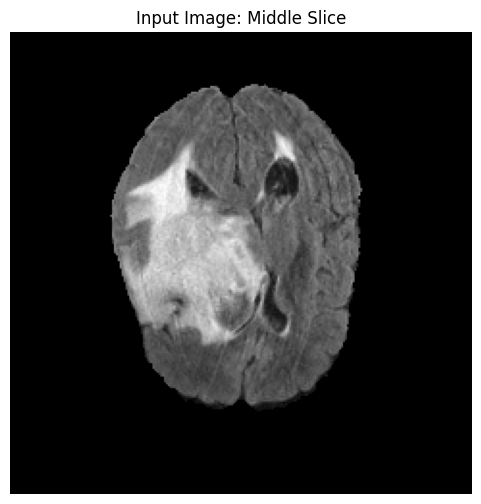

In [ ]:
# Plot the selected slice using Matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(slice_img.T, cmap="gray", origin="lower")
plt.title("Input Image: Middle Slice")
plt.axis("off")
plt.show()

 ## Step 2: Preprocessing

 We perform three preprocessing operations:

 1. **Noise Reduction:** Apply a Gaussian filter to reduce noise.
 2. **Normalization:** Scale image intensities to the range [0, 1].
 3. **Enhancement:** Apply histogram equalization to improve contrast.

 For demonstration purposes, we will process one slice (the middle slice) of the 3D volume.

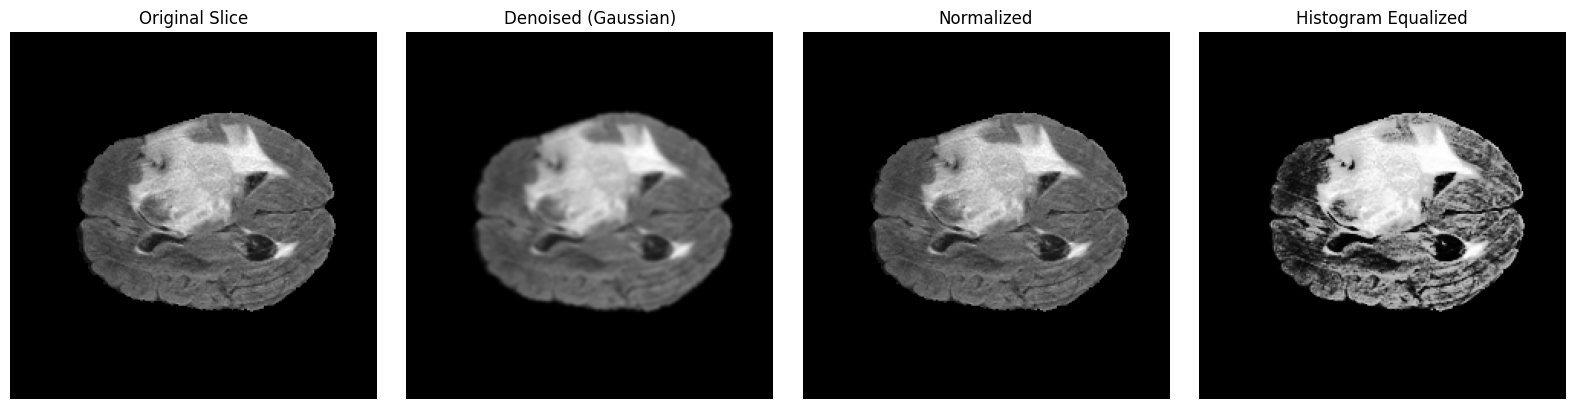

In [ ]:
from scipy.ndimage import gaussian_filter
from skimage import exposure

# 1. Noise Reduction using a Gaussian filter
sigma = 1  # standard deviation for Gaussian kernel
denoised = gaussian_filter(slice_img, sigma=1)
# one single line of code. google how to use those libraries.

# 2. Normalization: Scale the intensities to [0, 1]
normalized = slice_img / np.max(slice_img)

# 3. Contrast Enhancement: Histogram Equalization
equalized = exposure.equalize_hist(slice_img)

# Plot the original slice, denoised, normalized, and equalized images
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(slice_img, cmap='gray')
axes[0].set_title("Original Slice")
axes[0].axis('off')

axes[1].imshow(denoised, cmap='gray')
axes[1].set_title("Denoised (Gaussian)")
axes[1].axis('off')

axes[2].imshow(normalized, cmap='gray')
axes[2].set_title("Normalized")
axes[2].axis('off')

axes[3].imshow(equalized, cmap='gray')
axes[3].set_title("Histogram Equalized")
axes[3].axis('off')

plt.tight_layout()
plt.show()


 ## Step 3: Segmentation



 *Note:* For clinical use, more advanced segmentation (e.g., deep learning-based) is generally required.



 ## 3.1 Otsu Thresholding Segmentation

Otsu's method finds an optimal global threshold to separate the foreground from the background.

Otsu threshold: 0.8014390733506944


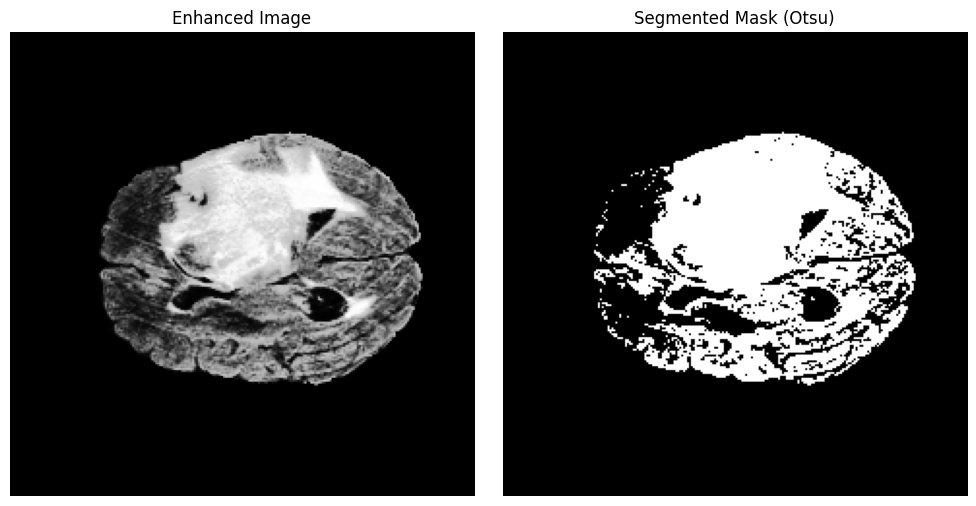

In [ ]:
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes

# Compute Otsu threshold on the equalized image
thresh = threshold_otsu(equalized)
print("Otsu threshold:", thresh)

# Create a binary mask (segmentation)
binary_mask = equalized > thresh


# Plot the segmentation result
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(equalized, cmap='gray')
ax[0].set_title("Enhanced Image")
ax[0].axis('off')

ax[1].imshow(binary_mask, cmap='gray')
ax[1].set_title("Segmented Mask (Otsu)")
ax[1].axis('off')

plt.tight_layout()
plt.show()


 ## 3.2 K-Means Clustering Segmentation

 We use K-Means to cluster pixel intensities into 2 clusters (e.g., background and tumor). \\


 **Exercise:** Implement K-means and Change the number of clusters to see how segmentation changes. Write your observation below

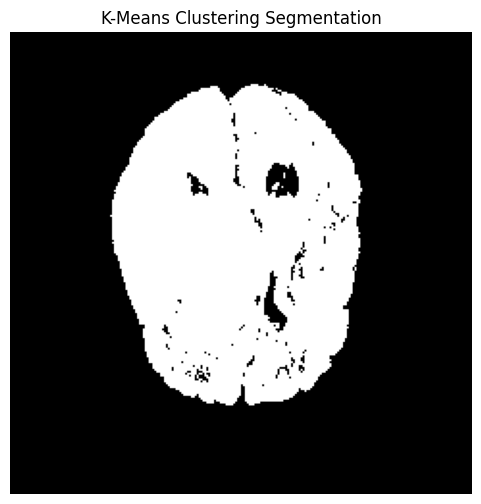

In [ ]:
from sklearn.cluster import KMeans

# Reshape image into (num_pixels, 1)
pixels = normalized.reshape(-1, 1)

kmeans = KMeans(n_clusters=2, random_state=42) # To be implemented
# fit the model
kmeans.fit(pixels)
labels = kmeans.labels_.reshape(normalized.shape)

# For visualization, assume the cluster with higher mean intensity represents the foreground.
cluster_means = [np.mean(normalized[labels == i]) for i in range(2)]
foreground_label = np.argmax(cluster_means)
binary_mask_kmeans = labels == foreground_label

plt.figure(figsize=(6,6))
plt.imshow(binary_mask_kmeans.T, cmap='gray', origin="lower")
plt.title("K-Means Clustering Segmentation")
plt.axis("off")
plt.show()